![marchmadness](https://pbs.twimg.com/profile_images/709113934096297984/2d4DKiR7.jpg)
<br>
<center>A Predictive Model by Brandon Price, Brett Henderson, Nik Cable, & Thomas Negron </center>

# Introduction
[Data Cleaning](#Data-Cleaning)<br>
[Data Exploration](#Data-Exploration)<br>
[Modeling](#Modeling)<br>
[Analysis](#Analysis)<br>
[Conclusion](#Conclusion)

### Motivation

Every March, about 40 million Americans fill out a bracket for the NCAA Basketball Tournament, informally called March Madness. There is an estimated $2 billion market surrounding these games. Whether you are putting money on your bracket or just looking for bragging rights, we want to help you out. We have developed a model that predicts the winner of each game based on each team's regular season performance. We look at some of the most basic stats (winning percentage, margin of victory, etc.), more detailed stats (rebounds, assists, etc.), and some more advanced metrics (RPI, SOS, etc.) to create the best possible prediction for each matchup. This model will provide us with predictions for each match, which can then be used to fill in a bracket.

### Objectives

At the end of the project, we were hoping to be able to determine these three things:

- Developing a model that will give us the bracket that we see as "most likely." This bracket would just pick every matchup with whichever team the model sees as having a better chance to win.

- Using the same model to determine which bracket choices are most overrated. Is the general public overrating one team compared to our model? If so, it may be in your interest to pick more upsets in your bracket, to maximize your chance of winning your pool.

- Determining which factors seem most important when predicting success in the tournament. This may provide greater insight to college basketball teams when determining any decision from who to recruit to developing a style of play.

# Data Cleaning
[Introduction](#Introduction) <br>
[Data Exploration](#Data-Exploration) <br>
[Modeling](#Modeling) <br>
[Analysis](#Analysis) <br>
[Conclusion](#Conclusion)

### Load in libraries.

In [77]:
import numpy as np
import pandas as pd
import warnings
import random
import copy
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import BaggingClassifier as Bagging
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as LinReg
from scipy import stats
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
""

''

### Load in Data

In [3]:
# Load in all datasets.
RegCompact = pd.read_csv('data/RegularSeasonCompactResults.csv')
RegDetailed = pd.read_csv('data/RegularSeasonDetailedResults.csv')
Teams = pd.read_csv('data/Teams.csv')
TournCompact = pd.read_csv('data/TourneyCompactResults.csv')
TournDetailed = pd.read_csv('data/TourneyDetailedResults.csv')
TournSeeds = pd.read_csv('data/TourneySeeds.csv')
TournSlots = pd.read_csv('data/TourneySlots.csv')
Seasons = pd.read_csv('data/Seasons.csv')

In [4]:
# Look at the size of each dataset.
print 'RegCompact :', RegCompact.shape
print 'RegDetailed :', RegDetailed.shape
print 'TournCompact :', TournCompact.shape
print 'TournDetailed :', TournDetailed.shape
print 'TournSeeds :', TournSeeds.shape
print 'TournSlots :', TournSlots.shape
print 'Seasons :', Seasons.shape

RegCompact : (145289, 8)
RegDetailed : (71241, 34)
TournCompact : (1983, 8)
TournDetailed : (847, 34)
TournSeeds : (2082, 3)
TournSlots : (2050, 4)
Seasons : (32, 6)


### Dataset Descriptions
**RegCompact:**  Regular season compact data on winning and losing teams.
<br>
**RegDetailed:**  Regular season extensive data on game statistics.
<br>
**Teams:**  Dataset containing all team names and ID's.
<br>
**TournCompact:**  Tournament compact data on winning and losing teams.
<br>
**TournDetailed:**  Tournament extensive data game statistics.
<br>
**TournSeeds:**  Dataset on the seeds for each team in the tournament.
<br>
**TournSlots:**  Dataset that tells who plays who after during which rounds.
<br>
**Season:**  Dataset that tells which region is which in TournSlots.

These datasets are comprehensive, but let's also use strength of schedule and rating percentage index.  We can pull these from cbs sports.

In [5]:
import urllib
from bs4 import BeautifulSoup

def ExtractSOS(link):
    metamorphosis = urllib.urlopen(link).read()
    soup = BeautifulSoup(metamorphosis, "lxml")
    table = soup.find_all('table')[0]
    data = table.find_all('tr')[3:]
    stats = np.zeros((1,len(data[1].contents)))
    for row in data:
        statsrow = []
        for col in row.contents:
            statsrow.append(col.text)
        statsarr = np.array(statsrow).reshape(-1,1).T
        stats = np.concatenate((stats,statsarr), axis = 0)
    stats = np.delete(stats, 0, 0)
    cols = ['SOSRank', 'School', 'W/L', 'SOS', 'OppWin%', 'NCSOSRank', 'NCW/L', 'NCSOS', 'RPIRank', 'RPI']
    return pd.DataFrame(data=stats,index=None,columns=cols)

# SOS data for years 2003-2015
links = ['http://www.cbssports.com/collegebasketball/bracketology/sos/2003-04','http://www.cbssports.com/collegebasketball/bracketology/sos/2004-05','http://www.cbssports.com/collegebasketball/bracketology/sos/2005-06','http://www.cbssports.com/collegebasketball/bracketology/sos/2006-07','http://www.cbssports.com/collegebasketball/bracketology/sos/2007-08','http://www.cbssports.com/collegebasketball/bracketology/sos/2008-09','http://www.cbssports.com/collegebasketball/bracketology/sos/2009-10','http://www.cbssports.com/collegebasketball/bracketology/sos/2010-11','http://www.cbssports.com/collegebasketball/bracketology/sos/2011-12','http://www.cbssports.com/collegebasketball/bracketology/sos/2012-13','http://www.cbssports.com/collegebasketball/bracketology/sos/2013-14','http://www.cbssports.com/collegebasketball/bracketology/sos/2014-15','http://www.cbssports.com/collegebasketball/bracketology/sos/2015-16']

# extract SOS and RPI data for years 2003-2015
SOSbyYear = []
for year in np.arange(2003, 2016):
    link = links[year-2003]
    SOSbyYear.append(ExtractSOS(link))
    
SOSbyYear[2].head()

,SOSRank,School,W/L,SOS,OppWin%,NCSOSRank,NCW/L,NCSOS,RPIRank,RPI
0,1,Kansas,23-6,0.6252,0.6577 (1),1,10-1,0.6769,1,0.6693
1,2,Oklahoma State,23-6,0.6052,0.6318 (2),9,9-1,0.5986,5,0.6574
2,3,Missouri,16-16,0.5960,0.6187 (3),13,8-6,0.5879,72,0.5542
3,4,Duke,25-5,0.5937,0.6113 (5),46,11-0,0.5437,4,0.6576
4,5,Connecticut,22-7,0.5909,0.6118 (4),32,8-3,0.5492,13,0.6264


We now need to link the team id's to the new data.  Unfortunately not all of the school names are written out the same way as the other data set so we need go through them manually and hard code the correct names.

In [6]:
# add team id's to the new data

for df in SOSbyYear:
    schoolid = []
    for school in df['School']:
        if school in Teams['Team_Name'].values:
            schoolid.append(Teams[Teams['Team_Name']==school]['Team_Id'].values[0])
        elif school[-5:] == 'State':
            school = school[:-5] + 'St'
            if school in Teams['Team_Name'].values:
                schoolid.append(Teams[Teams['Team_Name']==school]['Team_Id'].values[0])
            else:
                schoolid.append(0)
        else:
            schoolid.append(0)
    schoolid = np.array(schoolid)
    df['Team_Id'] = schoolid
    
missing = []
for year in np.arange(2003,2016):
    tourney = TournSeeds[TournSeeds['Season']==year]
    for teamid in tourney['Team']:
        if teamid not in SOSbyYear[year-2003]['Team_Id'].values:
            missing.append((Teams[Teams['Team_Id'] == teamid]['Team_Name'].values[0]))
missing = np.array(missing)
missing = np.unique(missing)
print missing
    
# names that don't match up in the new dataset and need to be changed
originals = ['Albany', 'American','Arkansas-Little Rock','Arkansas-Pine Bluff',\
                      'Brigham Young','Boston University','Central Michigan','Cal Poly',\
                     'Central Connecticut State','Coastal Carolina','Eastern Kentucky',\
                     'Eastern Washington','East Tennessee State','Fairleigh Dickinson',\
                     'Florida Gulf Coast','George Washington','Illinois-Chicago','IU-Purdue Indianapolis',\
                     'Kent State','Louisiana State','Long Island','Loyola-Maryland','Mississippi Valley State',\
                     'Middle Tennessee State','Miami (FL)','Miami (OH)','Mississippi','Monmouth',"Mount St. Mary's",\
                     'Northern Colorado','North Dakota State','North Carolina A&T','North Carolina Central',\
                     'North Carolina State','Northwestern State','Pennsylvania','South Carolina State',\
                     'South Dakota State','Southern Illinois','Southeastern Louisiana','Stephen F. Austin',\
                     'UC Santa Barbara','Southern University','St. Bonaventure',"St. John's","Saint Joseph's",\
                     'Saint Louis',"St. Mary's","St. Peter's",'Texas A&M-Corpus Christi','Texas Southern',\
                     'Alabama-Birmingham','Central Florida','Louisiana-Lafayette','Maryland-Baltimore County',\
                     'UNC Asheville','Nevada-Las Vegas','Southern California','Texas-Arlington','Texas-San Antonio',\
                     'Texas-El Paso','Virginia Commonwealth','Western Michigan','UW Milwaukee','Western Kentucky']

# change the incorrect names

for i in range(len(SOSbyYear)):
    year = SOSbyYear[i]
    for j in range(year.shape[0]):
        school = year.iloc[j]['School'];
        if school in originals:
            revised = missing[originals.index(school)]
            SOSbyYear[i] = year.set_value(j,'School', revised)
            
# re-add team id's to the new data, with the team names corrected

for df in SOSbyYear:
    schoolid = []
    for school in df['School']:
        if school in Teams['Team_Name'].values:
            schoolid.append(Teams[Teams['Team_Name']==school]['Team_Id'].values[0])
        elif school[-5:] == 'State':
            school = school[:-5] + 'St'
            if school in Teams['Team_Name'].values:
                schoolid.append(Teams[Teams['Team_Name']==school]['Team_Id'].values[0])
            else:
                schoolid.append(0)
        else:
            schoolid.append(0)
    schoolid = np.array(schoolid)
    df['Team_Id'] = schoolid
    
print 'done'

['Albany NY' 'American Univ' 'Ark Little Rock' 'Ark Pine Bluff' 'BYU'
 'Boston Univ' 'C Michigan' 'Cal Poly SLO' 'Central Conn' 'Coastal Car'
 'E Kentucky' 'E Washington' 'ETSU' 'F Dickinson' 'FL Gulf Coast'
 'G Washington' 'IL Chicago' 'IUPUI' 'Kent' 'LSU' 'Long Island' 'Loyola MD'
 'MS Valley St' 'MTSU' 'Miami FL' 'Miami OH' 'Mississippi' 'Monmouth NJ'
 "Mt St Mary's" 'N Colorado' 'N Dakota St' 'NC A&T' 'NC Central' 'NC State'
 'Northwestern LA' 'Penn' 'S Carolina St' 'S Dakota St' 'S Illinois'
 'SE Louisiana' 'SF Austin' 'Santa Barbara' 'Southern Univ'
 'St Bonaventure' "St John's" "St Joseph's PA" 'St Louis' "St Mary's CA"
 "St Peter's" 'TAM C. Christi' 'TX Southern' 'UAB' 'UCF' 'ULL' 'UMBC'
 'UNC Asheville' 'UNLV' 'USC' 'UT Arlington' 'UT San Antonio' 'UTEP'
 'VA Commonwealth' 'W Michigan' 'WI Milwaukee' 'WKU']
done


The data that we'll need to use in order to train our model is spread across multiple dataframes so we'll need ot create a "master team stats dataframe.

In [7]:
# develop a function to get the stats for a team in a given year
def getstats(teamid,season):
    
    # initialize a few dataframes that will be important for getting the stats
    whentheywon = RegDetailed[(RegDetailed['Season']==season) & (RegDetailed['Wteam']==teamid)]
    whentheylost = RegDetailed[(RegDetailed['Season']==season) & (RegDetailed['Lteam']==teamid)]
    alltheirgames = RegDetailed[(RegDetailed['Season']==season) & ((RegDetailed['Wteam']==teamid) | (RegDetailed['Lteam']==teamid))]
    
    # get regular season stats
    # Losses -- account for possibility of undefeated team
    if teamid in RegDetailed[RegDetailed['Season']==season]['Lteam'].values:
        reglosscount = RegDetailed[RegDetailed['Season']==season]['Lteam'].value_counts()[teamid]
    else: reglosscount = 0
        
    weightedwins = 0
    # Wins -- account for possibility of nonwinning team
    if teamid in RegDetailed[RegDetailed['Season']==season]['Wteam'].values:
        regwincount = RegDetailed[RegDetailed['Season']==season]['Wteam'].value_counts()[teamid]
        for loser in whentheywon['Lteam']:
            if loser in TournSeeds[TournSeeds['Season']==season]['Team'].values:
                lseed = float(TournSeeds[(TournSeeds['Season']==season) & (TournSeeds['Team']==loser)]['Seed'].values[0][1:3])
                weightedwins += 1.0/lseed        
    else: regwincount = 0
    
    # get momentum score
    teamgames = alltheirgames.reset_index(drop=True)

    winnums = 0

    for i in range(teamgames.shape[0] - 10, teamgames.shape[0]):
        
        if teamgames.loc[i]['Wteam'] == teamid:
            winnums += 1
        
    momentum = winnums
    
    # get rest of regular season stats
    regwinperc = float(regwincount)/float(regwincount+reglosscount) 
    pointsfor = whentheywon['Wscore'].sum() + whentheylost['Lscore'].sum()   
    pointsagainst = whentheywon['Lscore'].sum() + whentheylost['Wscore'].sum()   
    percpointswon = float(pointsfor)/float(pointsfor + pointsagainst)
    avgwinmargin = float(whentheywon['Wscore'].sum() - whentheywon['Lscore'].sum())/float(regwincount+reglosscount)
    avglossmargin = float(whentheylost['Lscore'].sum() - whentheylost['Wscore'].sum())/float(regwincount+reglosscount) 
    avgmargin = avgwinmargin + avglossmargin
    avgfgp = float(whentheywon['Wfgm'].sum() + whentheylost['Lfgm'].sum())/float(whentheywon['Wfga'].sum() + whentheylost['Lfga'].sum())
    avgfgp3 = float(whentheywon['Wfgm3'].sum() + whentheylost['Lfgm3'].sum())/float(whentheywon['Wfga3'].sum() + whentheylost['Lfga3'].sum())
    avgft = float(whentheywon['Wftm'].sum() + whentheylost['Lftm'].sum())/float(whentheywon['Wfta'].sum() + whentheylost['Lfta'].sum())
    avgor = float(whentheywon['Wor'].sum() + whentheylost['Lor'].sum())/float(regwincount+reglosscount)
    avgdr = float(whentheywon['Wdr'].sum() + whentheylost['Ldr'].sum())/float(regwincount+reglosscount)
    avgast = float(whentheywon['Wast'].sum() + whentheylost['Last'].sum())/float(regwincount+reglosscount)
    avgblk = float(whentheywon['Wblk'].sum() + whentheylost['Lblk'].sum())/float(regwincount+reglosscount)
    avgstl = float(whentheywon['Wstl'].sum() + whentheylost['Lstl'].sum())/float(regwincount+reglosscount)
    avgpf = float(whentheywon['Wpf'].sum() + whentheylost['Lpf'].sum())/float(regwincount+reglosscount)
    if teamid in SOSbyYear[season-2003]['Team_Id'].values:
        RPI = float(SOSbyYear[season-2003][SOSbyYear[season-2003]['Team_Id'] == teamid]['RPI'].values[0])
        SOS = float(SOSbyYear[season-2003][SOSbyYear[season-2003]['Team_Id'] == teamid]['SOS'].values[0])
    else: 
        RPI = 0.0
        SOS = 0.0
    # tournament seed?
    if teamid in TournSeeds[TournSeeds['Season']==season]['Team'].values:
        seed = int(TournSeeds[(TournSeeds['Season']==season) & (TournSeeds['Team']==teamid)]['Seed'].values[0][1:3])
    else: seed = 0
    
    # return stats
    return [seed,regwinperc,percpointswon,avgmargin,avgfgp,avgfgp3,
        avgft,avgor,avgdr,avgast,avgblk,avgstl,avgpf,momentum,weightedwins,RPI,SOS]

In [8]:
# make a dataframe for each year with every tournament teams' stats

# create new column names list for dataframe
collist = ['Seed','RegWin%','PointsWon%','AvgMargin','AvgFg%','AvgFg3%','AvgFt%','AvgOr',
           'AvgDr','AvgAst','AvgBlk','AvgStl','AvgPf','Momentum','WeightedWins','RPI','SOS']

# initialize a list to hold dataframes for different years
yearlist = []

for year in np.arange(2003,2016):
    
    newdat = Teams.copy()
    
    # create a new dataframe to hold teamdata
    teamframe = pd.DataFrame(columns=collist)

    # make a list to hold indices that need to be removed
    idxlist = []
    
    # populate teamdata dataframe
    for team in newdat['Team_Id']:
        if (team not in RegDetailed[RegDetailed['Season']==year]['Wteam'].values) and (team not in RegDetailed[RegDetailed['Season']==year]['Lteam'].values):
            idxlist.append(newdat[newdat['Team_Id']==team].index[0])
        else: teamframe = teamframe.append(pd.DataFrame([getstats(team,year)],columns=collist),ignore_index=True)
    
    # append teamdata to original (TourneySeed) frame
    finaldat = pd.concat([newdat.drop(idxlist).reset_index(drop=True),teamframe],axis=1)
    
    # put the dataframe in the yearlist
    yearlist.append(finaldat)
    
    print year, 'done'
    
yearlist[2].head()

2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done


,Team_Id,Team_Name,Seed,RegWin%,PointsWon%,AvgMargin,AvgFg%,AvgFg3%,AvgFt%,AvgOr,AvgDr,AvgAst,AvgBlk,AvgStl,AvgPf,Momentum,WeightedWins,RPI,SOS
0,1102,Air Force,0,0.586207,0.526222,6.103448,0.448699,0.364407,0.728232,7.620690,15.413793,13.655172,1.724138,8.793103,16.482759,5,0.083333,0.5259,0.4918
1,1103,Akron,0,0.642857,0.519430,5.357143,0.444302,0.381271,0.682456,10.285714,23.071429,16.107143,3.857143,6.750000,18.821429,6,0.287775,0.5545,0.5151
2,1104,Alabama,5,0.766667,0.537785,10.600000,0.481646,0.390119,0.733524,10.233333,26.466667,13.833333,4.433333,5.200000,14.733333,7,0.656746,0.6204,0.5682
3,1105,Alabama A&M,16,0.551724,0.504661,1.275862,0.400935,0.301533,0.613514,12.931034,24.310345,13.137931,3.862069,10.620690,19.344828,7,0.000000,0.4591,0.4136
4,1106,Alabama St,0,0.500000,0.486026,-3.333333,0.381046,0.300221,0.649331,11.266667,22.400000,10.366667,2.000000,6.700000,17.466667,4,0.000000,0.4447,0.4288


Yearlist is a list of all of the combined statistics for each year.  It contains the following statistics:
<br>
**Team_Id:** The number associated with a specific team.
<br>
**Team_Name:** The name of the team.
<br>
**Seed:** The seed of a given team.  0 means they didn't make the tournament.
<br>
**RegWin%:** The regular season winning percentage.
<br>
**PointsWon%:** The percentage of points won in the regular season.
<br>
**AvgMargin:** The average regular season game margin.
<br>
**AvgFg%:** The average field goal percentage.
<br>
**AvgFg3%:** The average 3-pointer percentage.
<br>
**AvgOr:** The average offensive rebounds per game.
<br>
**AvgDr:** The average defensive rebounds per game.
<br>
**AvgAst:** The average assists per game.
<br>
**AvgBlk:** The average blocks per game.
<br>
**AvgStl:** The average steals per game.
<br>
**AvgPf:** The average personal fouls per game.
<br>
**Momentum:** The number of games won in the last 10 games of the regular season.
<br>
**WeightedWins:** Gives greater weight to wins with higher rated teams.
<br>
**RPI:** “Rating Percentage Index”.  A percentage that ranks a team based off of wins, losses, and strength of schedule.
<br>
**SOS:** “Strength of Schedule”.  A number that estimates the difficulty of a team’s schedule.

# Data Exploration
[Introduction](#Introduction) <br>
[Data Cleaning](#Data-Cleaning) <br>
[Modeling](#Modeling) <br>
[Analysis](#Analysis) <br>
[Conclusion](#Conclusion)

Let's plot our data and see which statistics would possibly work best as predictors in our model.  What we'll do is plot each team statistic against wins in the NCAA tournament for each team that made it to the tournament.

In [12]:
# Calculate the tournament win number.
win_num = pd.DataFrame(columns=['Season','Team','Tourn_Win_Num'])

index = 0

# Iterate through each year.
for year in range(2003,2016):
    
    # Iterate through each team.
    for team in TournSeeds[TournSeeds['Season'] == year]['Team'].unique():
        
        tourn_win_num = TournCompact[(TournCompact['Season'] == year) & (TournCompact['Wteam'] == team)].shape[0]
        win_num.loc[index] = pd.Series({'Season':year, 'Team':team, 'Tourn_Win_Num': tourn_win_num})
        index += 1

# Print out results.
win_num.head()

,Season,Team,Tourn_Win_Num
0,2003,1328,3
1,2003,1448,1
2,2003,1393,6
3,2003,1257,1
4,2003,1280,0


In [13]:
# Function for plotting stat against tourney wins.
def plot_pred_win_num (stat_name):
    
    new_pred_df = pd.DataFrame(columns = [stat_name, 'Team_Id', 'Season'])
    
    # Construct new dataframe for each year.
    for year in range(2003,2016):
        index = year - 2003
        
        stat_series = yearlist[index][stat_name]
        year_series = pd.Series(np.ones(len(stat_series)) * year)
        teamid_series = yearlist[index]['Team_Id']
        new_pred_df = new_pred_df.append(pd.DataFrame({stat_name:stat_series,'Team_Id':teamid_series,'Season':year_series}))

        
    # Get stat list for tourney win data.
    stat_list = []
    
    for i in range(win_num.shape[0]):
        season = win_num.loc[i]['Season']
        team = win_num.loc[i]['Team']
        stat = new_pred_df[(new_pred_df['Season'] == season) & (new_pred_df['Team_Id'] == team)][stat_name].values[0]
        
        stat_list.append(stat)
    
    x = np.array(stat_list).reshape(-1,1)
    y = win_num['Tourn_Win_Num'].as_matrix().reshape(-1,1)
    
    # Calculate linear regression.
    model = LinReg().fit(x,y)
    preds = model.predict(x)
    
    plt.scatter(x,y)
    plt.xlabel(stat_name)
    plt.ylabel('Tournament Win Number')
    plt.plot(x,preds)

In [41]:
# Plot each of the following statistics:
col_vals = yearlist[0].columns.values
col_vals

array(['Team_Id', 'Team_Name', 'Seed', 'RegWin%', 'PointsWon%',
       'AvgMargin', 'AvgFg%', 'AvgFg3%', 'AvgFt%', 'AvgOr', 'AvgDr',
       'AvgAst', 'AvgBlk', 'AvgStl', 'AvgPf', 'Momentum', 'WeightedWins',
       'RPI', 'SOS'], dtype=object)

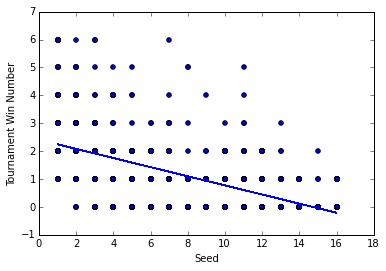

In [15]:
# Seed.
plot_pred_win_num('Seed')

Seed clearly has a negative correlation with tournament wins.  This is obvious and it has a pretty strong relationship.

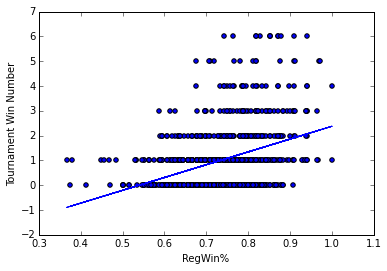

In [16]:
# RegWin%
plot_pred_win_num('RegWin%')

Regular Season Win Percentage has a fairly strong positive correlation with tournament wins.

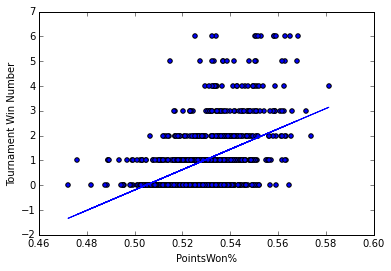

In [17]:
# PointsWon%
plot_pred_win_num('PointsWon%')

Points Won Percentage has a positive correlation with tournament wins.

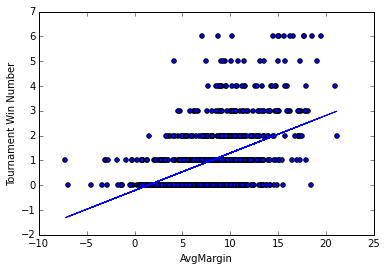

In [18]:
# AvgMargin
plot_pred_win_num('AvgMargin')

Average Game Margin has a strong positive correlation with tournament wins.

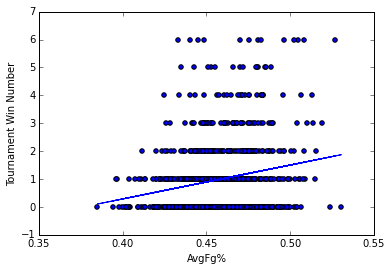

In [19]:
# AvgFg%
plot_pred_win_num('AvgFg%')

Average Field Goal Percentage doesn't have much of a correlation with tournament wins.

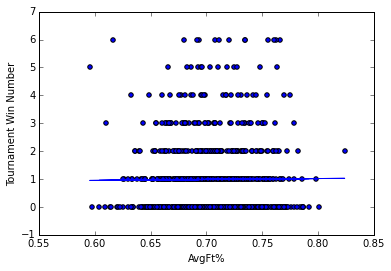

In [20]:
# AvgFt%
plot_pred_win_num('AvgFt%')

Average Free Throw Percentage has almost no correlation with tournament wins.

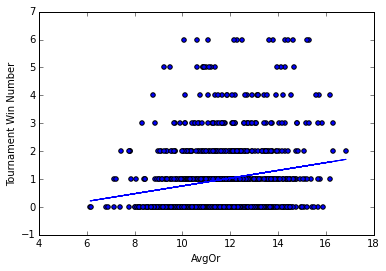

In [21]:
# AvgOr
plot_pred_win_num('AvgOr')

Average Offensive Rebounds has a positive correlation with tournament wins.

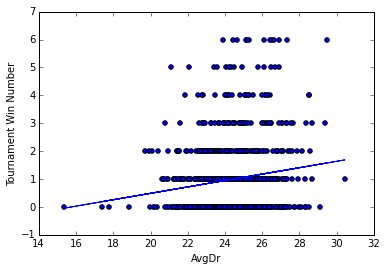

In [22]:
# AvgDr
plot_pred_win_num('AvgDr')

Average Defensive Rebound has a positive correlation with tournament wins.

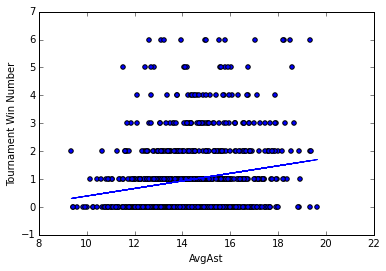

In [23]:
# AvgAst
plot_pred_win_num('AvgAst')

Average Assists has a weak positive correlation with tournament wins.

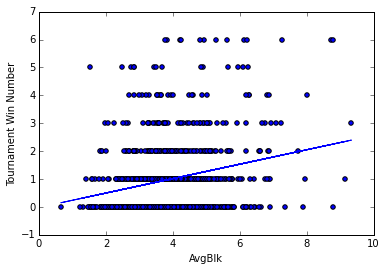

In [24]:
# AvgBlk
plot_pred_win_num('AvgBlk')

Average Blocks has a weak positive correlation with tournament wins.

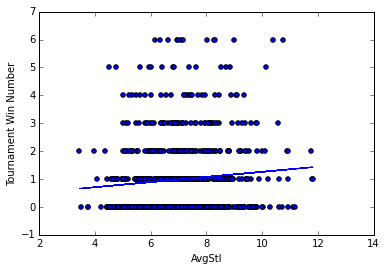

In [25]:
# AvgStl
plot_pred_win_num('AvgStl')

Average Steals doesn't seem to have much of a correlation with tournament wins.

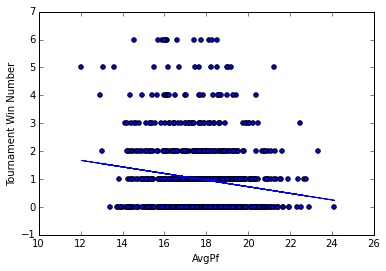

In [26]:
# AvgPf
plot_pred_win_num('AvgPf')

Average personal fouls has a nice negative correlation.

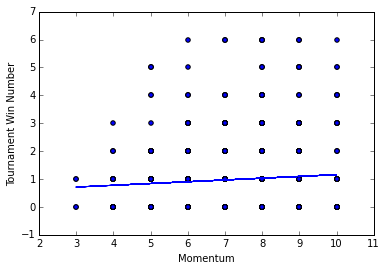

In [27]:
# Momentum
plot_pred_win_num('Momentum')

Momentum seems to have a decent correlation if you don't look at the regression line.

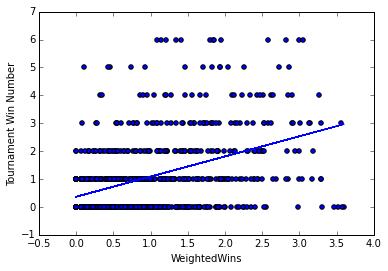

In [29]:
# Momentum
plot_pred_win_num('WeightedWins')

It's hard to say whether WeightedWins has a positive correlation because the large density gives the linear regression a positive slope.

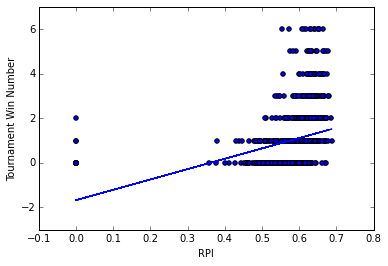

In [30]:
# Momentum
plot_pred_win_num('RPI')

RPI has a nice positive correlation with tournament wins.

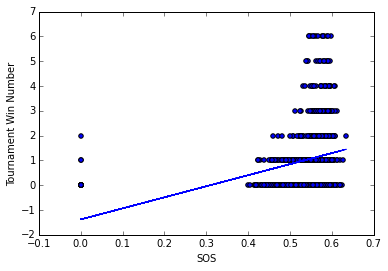

In [31]:
# Momentum
plot_pred_win_num('SOS')

Strength of Schedule has a nice positive correlation.

From these plots we can start thinking about modeling and which statistics work the best.

# Modeling
[Introduction](#Introduction) <br>
[Data Cleaning](#Data-Cleaning) <br>
[Data Exploration](#Data-Exploration) <br>
[Analysis](#Analysis) <br>
[Conclusion](#Conclusion)

Let's first create a baseline model that will predict only using Seed.  Most people that create March Madness brackets use Seed as their number one predictor.  Therefore this baseline model will tell us whether or not our future model is useful.

In [12]:
import random

# Function returns a 1 if team_a has a better seed than team_b and
# a 0 otherwise. If its a tie then it will randomly return either
# a 1 or a 0.
def Seed_Prediction (team_a, team_b, season):
    
    season_stats = yearlist[season]
    seed_a = season_stats[season_stats['Team_Id'] == team_a]['Seed'].values[0]
    seed_b = season_stats[season_stats['Team_Id'] == team_b]['Seed'].values[0]
    
    if seed_a < seed_b:
        return 1
    elif seed_a > seed_b:
        return 0
    else:
        if bool(random.getrandbits(1)):
            return 1
        else:
            return 0

In [13]:
# Calculate the accuracy of this baseline model.
correct_pred = 0.0
total_pred = 0.0

for i in range(TournCompact.shape[0]):
    
    team_a = TournCompact.loc[i]['Wteam']
    team_b = TournCompact.loc[i]['Lteam']
    season = TournCompact.loc[i]['Season']
    
    if season >= 2003:
        correct_pred += float(Seed_Prediction(team_a, team_b, season - 2003))
        total_pred += 1.0

print 'Baseline accuracy =', str(round(correct_pred / total_pred * 100,2)) + '%'

Baseline accuracy = 70.6%


Predicting purely off of seed yields roughly 70% accuracy which seems like a pretty good percentage.  However this is off of a game by game basis.  70% predicting accuracy per game doesn't mean 70% predicting accuracy for a bracket.  This model would have a much lower predicting accuracy for an entire bracket because the percentage compounds over the rounds.  Let's now try modeling based off of more predictors.

### Create Training and Testing Data

These next couple of functions create our training and testing data.  Our data creates a row for each tournament game by subtracting one team from another.  If the lower seed team beats the higher seed team then the corresponding responding variable is a 1, otherwise it is a 0.  This will be useful later when we try to predict upsets more accurately.

We create two types of training data: tuning and window.

The tuning training data is on all years except for the one that we test on.  We'll use 2007 because it is one of the most predictable years.  This is the best way to calculate our tuning parameters because it will incorporate all years that we have data on.

The window training data is for building the model that we are predicting on.  The window is the previous three years of data to the year that we are predicting on.  This is the best way for fitting our model after the tuning parameters are calculated because it will incorporate which stats are most important for the year we are predicting on.  The rules of basketball stay the same, however how people play it changes every few years.  Some years 3-pointers are more important than in other years.  The window training method should take this into account.

In [44]:
# develop training data (all tournament games from 2003-2016 minus the selected year)
def maketraindata(yeartodel, is_tuning):
    
    # include a few failsafes
    if (yeartodel < 2003) or (yeartodel > 2015):
        return 'You must choose a year to remove between 2003 and 2015.' 
        
    # initialize lists to hold data
    xtrain = []
    ytrain = []
    
    years = list(np.arange(2003,2016))
    
    # remove testing year from data
    copyyeardata = copy.deepcopy(yearlist)
    
    # If we're tuning then only remove the yeartodel.
    yearstodel = []
    
    if is_tuning:
        yearstodel.append(yeartodel-2003)
    # Delete everything except window of 5 years.
    else:
        yearstodel = range(2003-2003, yeartodel-3-2003) + range(yeartodel-2003, 2016-2003)
    
    # Delete yearstodel
    for i in sorted(yearstodel, reverse=True):
        del years[i]
        del copyyeardata[i]
    
    # generate training data
    for i in range(len(copyyeardata)):
        for index,row in TournDetailed[TournDetailed['Season']==years[i]].iterrows():
            if copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Wteam']].ix[:,2:]['Seed'].values <= copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Lteam']].ix[:,2:]['Seed'].values:
                team1 = row['Wteam']
                team2 = row['Lteam']
                team1stats = copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Wteam']].ix[:,2:].values
                team2stats = copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Lteam']].ix[:,2:].values
                xtrain.append(team1stats[0]-team2stats[0])
                ytrain.append(0)
            else:
                team1 = row['Lteam']
                team2 = row['Wteam']
                team1stats = copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Lteam']].ix[:,2:].values
                team2stats = copyyeardata[i].loc[copyyeardata[i]['Team_Id'] == row['Wteam']].ix[:,2:].values
                xtrain.append(team1stats[0]-team2stats[0])
                ytrain.append(1)
                
    xtrain_df, ytraindf = pd.DataFrame(xtrain,columns=collist),pd.DataFrame(ytrain,columns=['Winning Team'])
    
    # create training data
    xtrainunstand = np.array(xtrain_df)
    ytrain = np.array(ytraindf).ravel()

    # impute missing values for RPI and SOS with the mean:
    totRPI = float(np.sum(xtrainunstand[:,-2]))
    totSOS = float(np.sum(xtrainunstand[:,-1]))
    RPInot0 = [i for i in xtrainunstand[:,-2] if i > 0.0 ]
    SOSnot0 = [i for i in xtrainunstand[:,-1] if i > 0.0 ]
    numRPI = float(len(RPInot0))
    numSOS = float(len(SOSnot0))

    for i in range(xtrainunstand.shape[0]):
        if xtrainunstand[i,-2] == 0:
            xtrainunstand[i,-2] = totRPI/numRPI
            xtrainunstand[i,-1] = totSOS/numSOS

    # standardize x training data
    xtrain = xtrainunstand.copy()
    for i in range(xtrainunstand.shape[1]):
        xtrain[:,i] = (xtrainunstand[:,i] - np.mean(xtrainunstand[:,i]))/np.std(xtrainunstand[:,i])

    return xtrain, ytrain

In [45]:
# develop testing data (all tournament games from selected year)
def maketestdata(year):
    
    wlist = []
    llist = []
    widlist = []
    lidlist = []
    wseedlist = []
    lseedlist = []
    slotlist = []
    
    # include a few failsafes
    if (year < 2003) or (year > 2015):
        return 'You must choose a year to remove between 2003 and 2015.' 
    
    # create list for checking slots
    tuplist = zip(list(np.arange(1,17)),list(reversed(np.arange(1,17)))) + (zip(list(np.arange(11,17)),list(np.arange(11,17)))) 
        
    # initialize lists to hold data
    xtest = []
    ytest = []
    
    # generate testing data
    for index,row in TournDetailed[TournDetailed['Season']==year].iterrows():
        team1 = row['Wteam']
        team2 = row['Lteam']
        seed1 = TournSeeds[(TournSeeds['Season']==year) & (TournSeeds['Team']==team1)]['Seed'].values[0]
        seed2 = TournSeeds[(TournSeeds['Season']==year) & (TournSeeds['Team']==team2)]['Seed'].values[0]
            
        if seed1 <= seed2:
            widlist.append(team1)
            lidlist.append(team2)
            wseedlist.append(seed1)
            lseedlist.append(seed2)
            
            # get game slot
            if (seed1[0]==seed2[0]) & ((int(seed1[1:3]),int(seed2[1:3])) in tuplist) & ((len(seed1) < 4) | (len(seed2) < 4)):
                slotlist.append(TournSlots[(TournSlots['Season']==year) & (((TournSlots['Strongseed']==seed1[0:3]) & (TournSlots['Weakseed']==seed2[0:3])) | ((TournSlots['Strongseed']==seed2[0:3]) & (TournSlots['Weakseed']==seed1[0:3])))]['Slot'].values[0])
            elif (seed1[0]==seed2[0]) & ((int(seed1[1:3]),int(seed2[1:3])) in tuplist):
                slotlist.append(TournSlots[(TournSlots['Season']==year) & (((TournSlots['Strongseed']==seed1) & (TournSlots['Weakseed']==seed2)) | ((TournSlots['Strongseed']==seed2) & (TournSlots['Weakseed']==seed1)))]['Slot'].values[0])
            else: pass
            
            wlist.append(Teams[Teams['Team_Id']==team1]['Team_Name'].values[0])
            llist.append(Teams[Teams['Team_Id']==team2]['Team_Name'].values[0])
            team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == row['Wteam']].ix[:,2:].values
            team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == row['Lteam']].ix[:,2:].values
            xtest.append(team1stats[0]-team2stats[0])
            ytest.append(0)
            
        else:
            team1 = row['Lteam']
            team2 = row['Wteam']
            widlist.append(team2)
            lidlist.append(team1)
            seed1 = TournSeeds[(TournSeeds['Season']==year) & (TournSeeds['Team']==team1)]['Seed'].values[0]
            seed2 = TournSeeds[(TournSeeds['Season']==year) & (TournSeeds['Team']==team2)]['Seed'].values[0]
            wseedlist.append(seed2)
            lseedlist.append(seed1)
            
            # get game slot
            if (seed1[0]==seed2[0]) & ((int(seed1[1:3]),int(seed2[1:3])) in tuplist) & ((len(seed1) < 4) | (len(seed2) < 4)):
                slotlist.append(TournSlots[(TournSlots['Season']==year) & (((TournSlots['Strongseed']==seed1[0:3]) & (TournSlots['Weakseed']==seed2[0:3])) | ((TournSlots['Strongseed']==seed2[0:3]) & (TournSlots['Weakseed']==seed1[0:3])))]['Slot'].values[0])
            elif (seed1[0]==seed2[0]) & ((int(seed1[1:3]),int(seed2[1:3])) in tuplist): 
                slotlist.append(TournSlots[(TournSlots['Season']==year) & (((TournSlots['Strongseed']==seed1) & (TournSlots['Weakseed']==seed2)) | ((TournSlots['Strongseed']==seed2) & (TournSlots['Weakseed']==seed1)))]['Slot'].values[0])
            else: pass
            
            llist.append(Teams[Teams['Team_Id']==team1]['Team_Name'].values[0])
            wlist.append(Teams[Teams['Team_Id']==team2]['Team_Name'].values[0])
            team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == row['Lteam']].ix[:,2:].values
            team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == row['Wteam']].ix[:,2:].values
            xtest.append(team1stats[0]-team2stats[0])
            ytest.append(1)

    # create testing data
    xtestdf,ytestdf,slotlist,wlist,llist,widlist,lidlist,wseedlist,lseedlist = pd.DataFrame(xtest,columns=collist),pd.DataFrame(ytest,columns=['Winning Team']),slotlist,wlist,llist,widlist,lidlist,wseedlist,lseedlist
    xtestunstand = np.array(xtestdf)
    ytest = np.array(ytestdf).ravel()

    # impute missing values for RPI and SOS with the mean:
    totRPI = float(np.sum(xtestunstand[:,-2]))
    totSOS = float(np.sum(xtestunstand[:,-1]))
    RPInot0 = [i for i in xtestunstand[:,-2] if i > 0.0 ]
    SOSnot0 = [i for i in xtestunstand[:,-1] if i > 0.0 ]
    numRPI = float(len(RPInot0))
    numSOS = float(len(SOSnot0))

    for i in range(xtestunstand.shape[0]):
        if xtestunstand[i,-2] == 0:
            xtestunstand[i,-2] = totRPI/numRPI
            xtestunstand[i,-1] = totSOS/numSOS

    # standardize x training data
    xtest = xtestunstand.copy()
    for i in range(xtestunstand.shape[1]):
        xtest[:,i] = (xtestunstand[:,i] - np.mean(xtestunstand[:,i]))/np.std(xtestunstand[:,i])

    # create test dataframe for bracket making
    bracketstartlist = zip(slotlist,widlist,wseedlist,wlist,lidlist,lseedlist,llist)
    initialsetup = pd.DataFrame(bracketstartlist,columns=['Game Slot','Ateamid','Ateamseed','Ateam','Bteamid','Bteamseed','Bteam'])
    
    return xtest, ytest, bracketstartlist, initialsetup

In [46]:
# Create tuning, training data.
xtrain_tuning, ytrain_tuning = maketraindata(2007, True)

# Create window, training data.
xtrain_window, ytrain_window = maketraindata(2007, False)

# Create testing, bracket data.
xtest, ytest, bracketstartlist, initialsetup = maketestdata(2007)

print 'done'

done


### Tuning

Now that we have training and testing data, let's include some functions that will tune parameters for different types of models.  These functions will perform K-Fold cross validation on different models, plot the accuracies for the different tuning parameters, and then return the runing parameter with the best accuracy.

The last function, getaccuracy, fits the model with the best tuning paramter on the entire training set and then returns the max score for this model.  We're hoping to get a score higher than 70% in order to beat our baseline.

In [72]:
# Tuning function for neighbors in KNN
def tune_knn(x,y,k):
    # Split the training set into k folds
    kf = KFold(len(x), n_folds = k)

    # keep track of the mean accuracy for each C
    acc_test = []
    acc_train = []

    neighbors = [3,4,5,6,7,8,9]

    # iterate over each C and model each fold for the given C
    for num in neighbors:
        # initialize model
        model = KNN(n_neighbors=num)
        
        # keep track of the accuracy values for a given C so we can take the average
        acc_cv = []
        acc_tr = []

        # split the data into train and test using the kfold indices
        for train_index, test_index in kf:
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # fit the ridge model for the given C cv set
            model.fit(x_train, y_train)

            # Train and test accuracy for 
            acc_cv.append(model.score(x_test, y_test))
            acc_tr.append(model.score(x_train,y_train))

        # take the mean of the accuracy for each fold
        acc_test.append(np.mean(acc_cv))
        acc_train.append(np.mean(acc_tr))
        
    nicestneighbor = acc_test.index(max(acc_test))+3
    
    # plot the values of accuracy for the cv and test data for different values of C
    fig = plt.figure(figsize=(15, 10))
    plt.plot(neighbors, acc_test, 'b', label = 'Test Accuracy')
    plt.plot(neighbors, acc_train, 'r', label = 'Train Accuracy')
    plt.title('Train and Test CV Accuracy for Different Numbers of Neighbors')
    plt.xlabel('Neighbors')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'best')
    
    return nicestneighbor

In [73]:
# Tuning function for SVM and Logistic Regression
def tune_svmlogreg(x,y,k,modeltype,kernel='rbf'):
    # Split the training set into k folds
    kf = KFold(len(x), n_folds = k)

    # keep track of the mean accuracy for each C
    acc_test = []
    acc_train = []

    Cs = [10**i for i in range(-7, 8)]

    # iterate over each C and model each fold for the given C
    for C in Cs:
        # keep track of the accuracy values for a given C so we can take the average
        acc_cv = []
        acc_tr = []

        # make the model
        if modeltype == 'LogReg':
            model = LogReg(C=C)
        elif modeltype == 'SVM':
            model = SVC(C=C,kernel=kernel)

        # split the data into train and test using the kfold indices
        for train_index, test_index in kf:
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # fit the ridge model for the given C cv set
            model.fit(x_train, y_train)

            # Train and test accuracy for 
            acc_cv.append(model.score(x_test, y_test))
            acc_tr.append(model.score(x_train,y_train))

        # take the mean of the accuracy for each fold
        acc_test.append(np.mean(acc_cv))
        acc_train.append(np.mean(acc_tr))
    
    C = 10**(acc_test.index(max(acc_test))-7)
    
    # plot the values of accuracy for the cv and test data for different values of C
    fig = plt.figure(figsize=(15, 10))
    plt.plot(Cs, acc_test, 'b', label = 'Test Accuracy')
    plt.plot(Cs, acc_train, 'r', label = 'Train Accuracy')
    plt.title('Train and Test CV Accuracy for Different Values of C')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.legend(loc = 'best')
    
    return C

In [74]:
# build a function that tunes estimators, depth over training data (Random Forest)
def tune_forest(x,y,k):
    # Split the training set into k folds
    kf = KFold(len(x), n_folds = k)

    # create some important lists
    depth_2 = []
    depth_4 = []
    depth_6 = []
    depth_8 = []
    depth_10 = []
    depth_12 = []
    depthlists = [depth_2,depth_4,depth_6,depth_8,depth_10,depth_12]
    
    estimators = [10,25,50,100,250,500,1000]
    depths = [2,4,6,8,10,12]

    # iterate over each treecount
    for depth in depths:
        for estimator in estimators:

            model = RandomForest(n_estimators=estimator,max_depth=depth)
            
            acc_testdepth = []
            
            # split the data into train and test using the kfold indices
            for train_index, test_index in kf:
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # fit the model for the given C cv set
                model.fit(x_train, y_train)

                # Train and test accuracy for 
                acc_testdepth.append(model.score(x_test,y_test))

            # take the mean of the accuracy for each fold
            depthlists[depths.index(depth)].append(np.mean(acc_testdepth))
     
    # get best number of trees and depth of tree
    acclist = []
    
    for item in depthlists:
        bestacc = max(item)
        trees = estimators[item.index(max(item))]
        howdeep = depths[depthlists.index(item)]
        acclist.append((bestacc,trees,howdeep))
        
    acc,numtrees,thedepth = max(acclist,key=lambda element:element[0])
    
    # plot the values of accuracy for the cv and test data for different values of C
    fig = plt.figure(figsize=(15,11))
    plt.plot(estimators, depth_2, label='Depth 2')
    plt.plot(estimators, depth_4, label='Depth 4')
    plt.plot(estimators, depth_6, label='Depth 6')
    plt.plot(estimators, depth_8, label='Depth 8')
    plt.plot(estimators, depth_10, label='Depth 10')
    plt.plot(estimators, depth_12, label='Depth 12')
    plt.title('Test Accuracy for Different Depths and Numbers of Trees')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.legend(loc = 'best')
    
    return acc,numtrees,thedepth

In [75]:
def getaccuracy(modeltype,xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest):
    
    # select model to use
    if modeltype == 'KNN':
        nicestneighbor = tune_knn(xtrain_tuning,ytrain_tuning,20)
        print 'Nicest neighbor = {}'.format(nicestneighbor)
        model = KNN(n_neighbors=nicestneighbor)
    elif modeltype == 'LogReg':
        C = tune_svmlogreg(xtrain_tuning,ytrain_tuning,8,'LogReg')
        print 'Best C = '+str(C)
        model = LogReg(C=C)
    elif modeltype == 'LogReg_Balance':
        C = tune_svmlogreg(xtrain_tuning,ytrain_tuning,8,'LogReg')
        print 'Best C = '+str(C)
        model = LogReg(C=C, class_weight = 'balanced')
    elif modeltype == 'LDA':
        model = LDA()
    elif modeltype == 'QDA':
        model = QDA()
    elif modeltype == 'Random Forest':
        acc,estimators,depth = tune_forest(xtrain_tuning,ytrain_tuning,8)
        print 'n_estimators = {}, depth = {}'.format(estimators,depth)
        model = RandomForest(n_estimators=estimators,max_depth=depth)
    elif modeltype == 'SVM':
        C = tune_svmlogreg(xtrain_tuning,ytrain_tuning,8,'SVM',kernel='rbf')
        print 'Best C = '+str(C)
        model = SVC(C=C,kernel='rbf')
    
    model.fit(xtrain_window,ytrain_window)
    score = model.score(xtest,ytest)
    return 'Max Accuracy = '+str(score)

### K-Nearest Neighbors

Nicest neighbor = 9
Max Accuracy = 0.734375


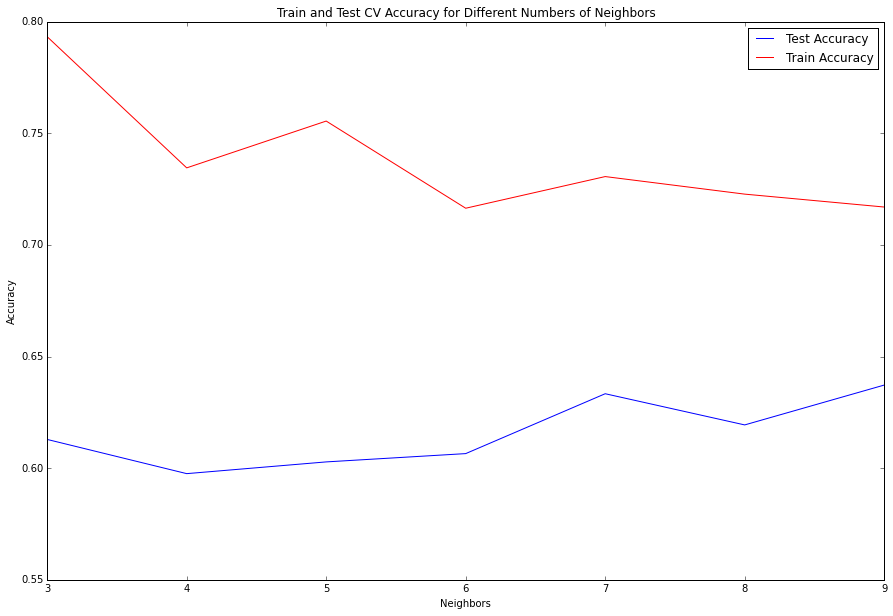

In [80]:
print getaccuracy('KNN',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

### Logistic Regression

Best C = 0.01
Max Accuracy = 0.71875


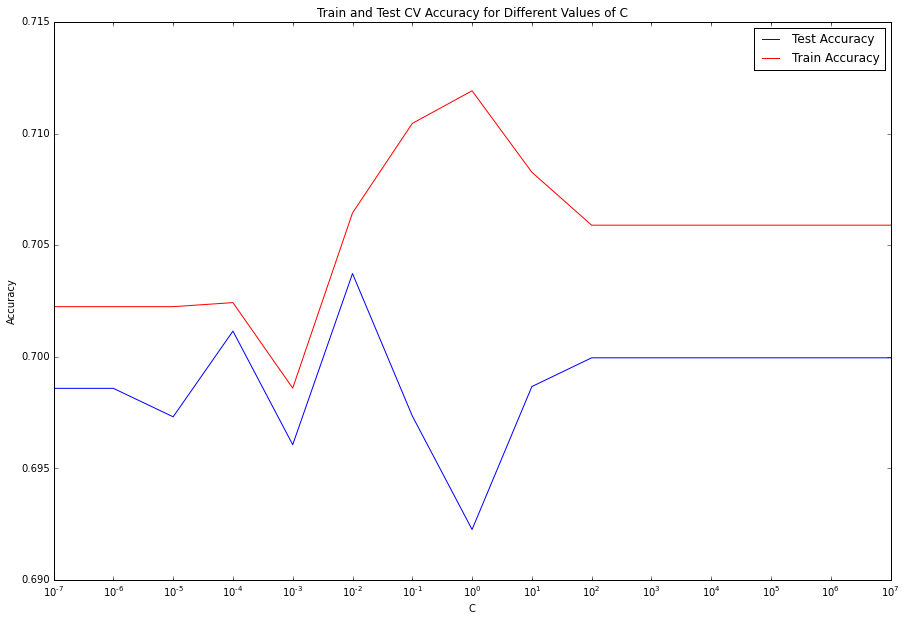

In [81]:
print getaccuracy('LogReg',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

In [82]:
print getaccuracy('LDA',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

Max Accuracy = 0.71875


In [83]:
print getaccuracy('QDA',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

Max Accuracy = 0.609375


Best C = 0.1
Max Accuracy = 0.75


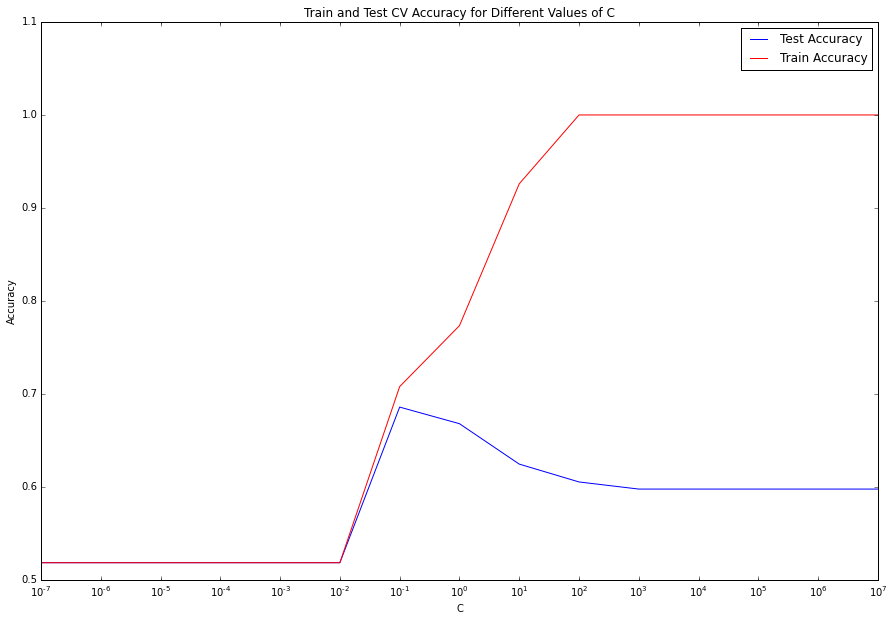

In [84]:
print getaccuracy('SVM',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

n_estimators = 50, depth = 6
Max Accuracy = 0.796875


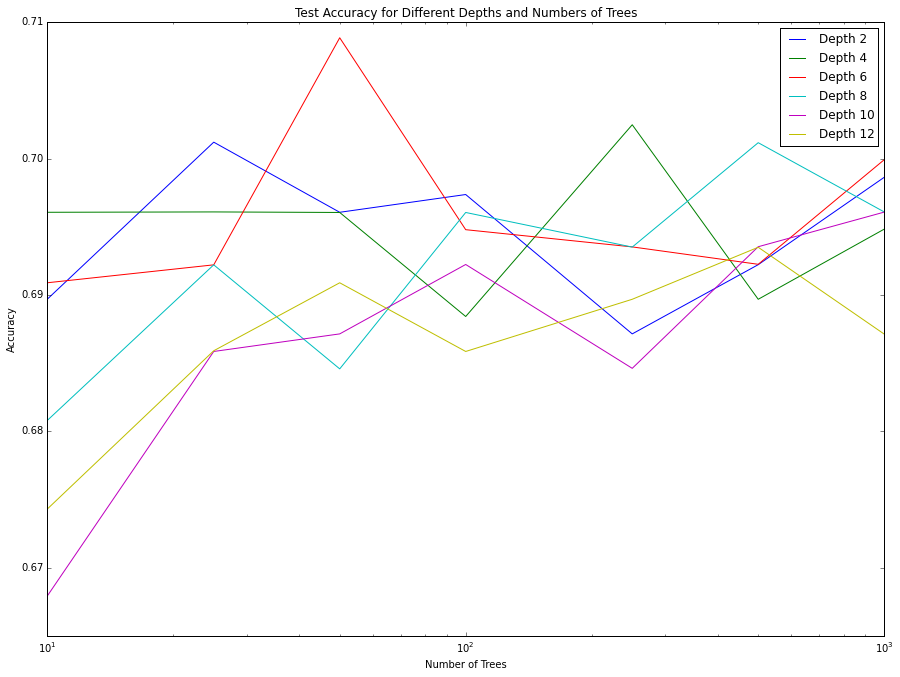

In [85]:
print getaccuracy('Random Forest',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

Now that we have calculated tuning parameters for each model, we can use these to fit each different type of model against each year to see which models perform better than others.

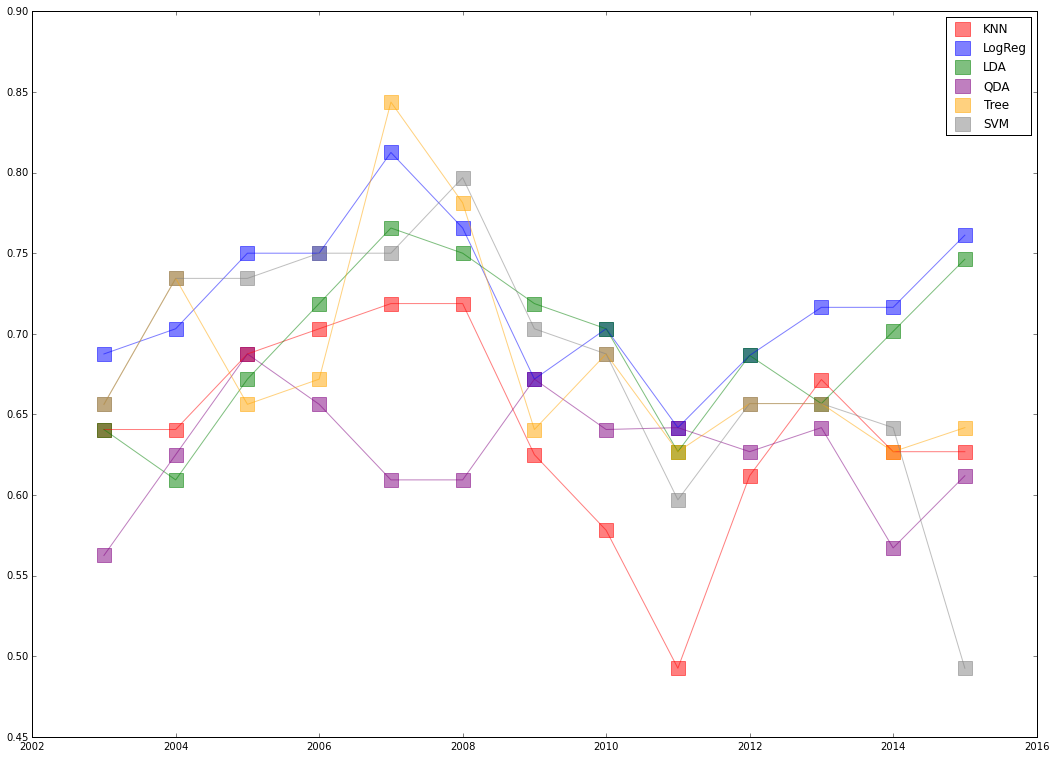

In [106]:
# now try running all the models on each set of test data

# initialize scorelists
knnscore = []
logregscore = []
ldascore = []
qdascore = []
rfscore = []
svmscore = []

years = np.arange(2003,2016)

for year in years:
    
    # make train data
    xtrain_yearly_window, ytrain_yearly_window = maketraindata(year,False)
    
    # make test data
    xtest_yearly, ytest_yearly, _, _ = maketestdata(year)
    
    # KNN Model
    knn = KNN(n_neighbors=9)
    knn.fit(xtrain_yearly_window, ytrain_yearly_window)
    knnscore.append(knn.score(xtest_yearly,ytest_yearly))
    
    # LogReg Model
    logreg = LogReg(C=0.01)
    logreg.fit(xtrain_yearly_window, ytrain_yearly_window)
    logregscore.append(logreg.score(xtest_yearly, ytest_yearly))
    
    # LDA Model
    lda = LDA()
    lda.fit(xtrain_yearly_window, ytrain_yearly_window)
    ldascore.append(lda.score(xtest_yearly, ytest_yearly))
    
    # QDA Model
    qda = QDA()
    qda.fit(xtrain_yearly_window, ytrain_yearly_window)
    qdascore.append(qda.score(xtest_yearly, ytest_yearly))
    
    # Random Forest Model
    rf = RandomForest(n_estimators=50,max_depth=6)
    rf.fit(xtrain_yearly_window, ytrain_yearly_window)
    rfscore.append(rf.score(xtest_yearly, ytest_yearly))
    
    # SVM
    svm = SVC(C=0.1)
    svm.fit(xtrain_yearly_window, ytrain_yearly_window)
    svmscore.append(svm.score(xtest_yearly, ytest_yearly))

# graph different scores

# plot scatters
fig = plt.figure(figsize=(18,13))
plt.scatter(years,knnscore,label='KNN',s=200,marker=',',color='r',alpha=0.5)
plt.scatter(years,logregscore,label='LogReg',s=200,marker=',',color='b',alpha=0.5)
plt.scatter(years,ldascore,label='LDA',s=200,marker=',',color='g',alpha=0.5)
plt.scatter(years,qdascore,label='QDA',s=200,marker=',',color='purple',alpha=0.5)
plt.scatter(years,rfscore,label='Tree',s=200,marker=',',color='orange',alpha=0.5)
plt.scatter(years,svmscore,label='SVM',s=200,marker=',',color='gray',alpha=0.5)

# connect scatters with lines
plt.plot(years,knnscore,color='r',alpha=0.5)
plt.plot(years,logregscore,color='b',alpha=0.5)
plt.plot(years,ldascore,color='g',alpha=0.5)
plt.plot(years,qdascore,color='purple',alpha=0.5)
plt.plot(years,rfscore,color='orange',alpha=0.5)
plt.plot(years,svmscore,color='gray',alpha=0.5)

plt.legend(loc='best',scatterpoints=1)
#plt.xlabel('Year')
#plt.ylabel('Accuracy')
#plt.title('Model Accuracy Across Tournament Years')
plt.show()

Random forests perform the best in 2007, but thats it.  Overall logistic regression appears to be the best for most years.  Since logistic regression performs the best in 2015, we'll use it to build our bracket.

## Building our bracket.
These next few functions build a bracket for us.

In [57]:
# initialize slotlists
round1oldslots = [('R1W1','R1W8'),('R1W2','R1W7'),('R1W3','R1W6'),('R1W4','R1W5'),
            ('R1X1','R1X8'),('R1X2','R1X7'),('R1X3','R1X6'),('R1X4','R1X5'),
            ('R1Y1','R1Y8'),('R1Y2','R1Y7'),('R1Y3','R1Y6'),('R1Y4','R1Y5'),
            ('R1Z1','R1Z8'),('R1Z2','R1Z7'),('R1Z3','R1Z6'),('R1Z4','R1Z5')]
round1newslots = ['R2W1','R2W2','R2W3','R2W4','R2X1','R2X2','R2X3','R2X4',
            'R2Y1','R2Y2','R2Y3','R2Y4','R2Z1','R2Z2','R2Z3','R2Z4']

round2oldslots = [('R2W1','R2W4'),('R2W2','R2W3'),('R2X1','R2X4'),('R2X2','R2X3'),
            ('R2Y1','R2Y4'),('R2Y2','R2Y3'),('R2Z1','R2Z4'),('R2Z2','R2Z3')]
round2newslots = ['R3W1','R3W2','R3X1','R3X2','R3Y1','R3Y2','R3Z1','R3Z2']

round3oldslots = [('R3W1','R3W2'),('R3X1','R3X2'),('R3Y1','R3Y2'),('R3Z1','R3Z2')]
round3newslots = ['R4W1','R4X1','R4Y1','R4Z1']

In [58]:
# start by predicting the wild card (play-in) games and returning the initial regular bracket
def predictwcs(dataframe,year,model):
    
    # create lists to hold results
    newslotlist = []
    wteamidlist = []
    wteamseedlist = []
    wteamlist = []
    lteamidlist = []
    lteamseedlist = []
    lteamlist = []

    compdat = dataframe.copy()

    for index,row in compdat.iterrows():
        if len(row['Game Slot']) < 4:
            if np.random.rand() <= 0.5:
                team1 = row['Ateamid']
                team2 = row['Bteamid']
                team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team1].ix[:,2:].values
                team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team2].ix[:,2:].values
                preds = team1stats[0]-team2stats[0]
                result = model.predict(preds.reshape(-1,len(preds)))
                newslotlist.append(row['Game Slot'])
                if result == 0:
                    wteamidlist.append(team1)
                    wteamseedlist.append(row['Ateamseed'])
                    wteamlist.append(row['Ateam'])
                    lteamidlist.append(team2)
                    lteamseedlist.append(row['Bteamseed'])
                    lteamlist.append(row['Bteam'])
                elif result == 1:
                    wteamidlist.append(team2)
                    wteamseedlist.append(row['Bteamseed'])
                    wteamlist.append(row['Bteam'])
                    lteamidlist.append(team1)
                    lteamseedlist.append(row['Ateamseed'])
                    lteamlist.append(row['Ateam'])
            else:
                team1 = row['Bteamid']
                team2 = row['Ateamid']
                team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team1].ix[:,2:].values
                team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team2].ix[:,2:].values
                preds = team1stats[0]-team2stats[0]
                result = model.predict(preds.reshape(-1,len(preds)))
                newslotlist.append(row['Game Slot'])
                if result == 0:
                    wteamidlist.append(team1)
                    wteamseedlist.append(row['Bteamseed'])
                    wteamlist.append(row['Bteam'])
                    lteamidlist.append(team2)
                    lteamseedlist.append(row['Ateamseed'])
                    lteamlist.append(row['Ateam'])
                elif result == 1:
                    wteamidlist.append(team2)
                    wteamseedlist.append(row['Ateamseed'])
                    wteamlist.append(row['Ateam'])
                    lteamidlist.append(team1)
                    lteamseedlist.append(row['Bteamseed'])
                    lteamlist.append(row['Bteam'])

    combinedlist = wteamidlist + lteamidlist

    for index,row in compdat.iterrows():
        if len(row['Game Slot']) > 3:
            if row['Ateamid'] in combinedlist:
                if row['Ateamid'] in wteamidlist: pass
                else: 
                    compdat.set_value(index,['Ateamid'],wteamidlist[lteamidlist.index(row['Ateamid'])])
                    compdat.set_value(index,['Ateamseed'],wteamseedlist[lteamseedlist.index(row['Ateamseed'])])
                    compdat.set_value(index,['Ateam'],wteamlist[lteamlist.index(row['Ateam'])])
            elif row['Bteamid'] in combinedlist:
                if row['Bteamid'] in wteamidlist: pass
                else: 
                    compdat.set_value(index,['Bteamid'],wteamidlist[lteamidlist.index(row['Bteamid'])])
                    compdat.set_value(index,['Bteamseed'],wteamseedlist[lteamseedlist.index(row['Bteamseed'])])
                    compdat.set_value(index,['Bteam'],wteamlist[lteamlist.index(row['Bteam'])])

    wcbracketlist = zip(newslotlist,wteamidlist,wteamseedlist,wteamlist,lteamidlist,lteamseedlist,lteamlist)
    wcpreds = pd.DataFrame(bracketstartlist,columns=['Game Slot','Wteamid','Wteamseed','Wteam','Lteamid','Lteamseed','Lteam'])

    for index,row in compdat.iterrows():
        if len(row['Game Slot']) < 4:
            compdat = compdat.drop([index])

    compdat.reset_index(drop=True)        
    R1setup = compdat.copy()
    R1setup.columns = ['Game Slot','Ateamid','Ateamseed','Ateam','Bteamid','Bteamseed','Bteam']
    return R1setup

In [59]:
# predict results of a round of the tournament (does NOT include play-in round)
def predictround(dataframe,year,model):
    
    newslotlist = []
    wteamidlist = []
    wteamseedlist = []
    wteamlist = []
    lteamidlist = []
    lteamseedlist = []
    lteamlist = []

    for index,row in dataframe.iterrows():
        if np.random.rand() <= 0.5:
            team1 = row['Ateamid']
            team2 = row['Bteamid']
            team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team1].ix[:,2:].values
            team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team2].ix[:,2:].values
            preds = team1stats[0]-team2stats[0]
            result = model.predict(preds.reshape(-1,len(preds)))
            newslotlist.append(row['Game Slot'])
            if result == 0:
                wteamidlist.append(team1)
                wteamseedlist.append(row['Ateamseed'])
                wteamlist.append(row['Ateam'])
                lteamidlist.append(team2)
                lteamseedlist.append(row['Bteamseed'])
                lteamlist.append(row['Bteam'])
            elif result == 1:
                wteamidlist.append(team2)
                wteamseedlist.append(row['Bteamseed'])
                wteamlist.append(row['Bteam'])
                lteamidlist.append(team1)
                lteamseedlist.append(row['Ateamseed'])
                lteamlist.append(row['Ateam'])
        else:
            team1 = row['Bteamid']
            team2 = row['Ateamid']
            team1stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team1].ix[:,2:].values
            team2stats = yearlist[year-2003].loc[yearlist[year-2003]['Team_Id'] == team2].ix[:,2:].values
            preds = team1stats[0]-team2stats[0]
            result = model.predict(preds.reshape(-1,len(preds)))
            newslotlist.append(row['Game Slot'])
            if result == 0:
                wteamidlist.append(team1)
                wteamseedlist.append(row['Bteamseed'])
                wteamlist.append(row['Bteam'])
                lteamidlist.append(team2)
                lteamseedlist.append(row['Ateamseed'])
                lteamlist.append(row['Ateam'])
            elif result == 1:
                wteamidlist.append(team2)
                wteamseedlist.append(row['Ateamseed'])
                wteamlist.append(row['Ateam'])
                lteamidlist.append(team1)
                lteamseedlist.append(row['Bteamseed'])
                lteamlist.append(row['Bteam'])
            
    Rresultslist = zip(newslotlist,wteamidlist,wteamseedlist,wteamlist,lteamidlist,lteamseedlist,lteamlist)
    Rresultsframe = pd.DataFrame(Rresultslist,columns=['Game Slot','Wteamid','Wteamseed','Wteam','Lteamid','Lteamseed','Lteam'])
    return Rresultsframe

In [60]:
# set up the next round of play using results from last round (NOT play-in round)
def setupround(resultsfromlast,oldslots,newslots):
    
    Ateamlist = []
    Bteamlist = []
    Ateamidlist = []
    Bteamidlist = []
    Ateamseedlist = []
    Bteamseedlist = []
    newslotlist = newslots
    oldslotlist = oldslots
    
    for item in oldslotlist:
        high, low = item
    
        Ateamidlist.append(resultsfromlast[resultsfromlast['Game Slot']==high]['Wteamid'].values[0])
        Ateamseedlist.append(resultsfromlast[resultsfromlast['Game Slot']==high]['Wteamseed'].values[0])
        Ateamlist.append(resultsfromlast[resultsfromlast['Game Slot']==high]['Wteam'].values[0])
        
        Bteamidlist.append(resultsfromlast[resultsfromlast['Game Slot']==low]['Wteamid'].values[0])
        Bteamseedlist.append(resultsfromlast[resultsfromlast['Game Slot']==low]['Wteamseed'].values[0])
        Bteamlist.append(resultsfromlast[resultsfromlast['Game Slot']==low]['Wteam'].values[0])
    
    setuplist = zip(newslotlist,Ateamidlist,Ateamseedlist,Ateamlist,Bteamidlist,Bteamseedlist,Bteamlist)
    setupframe = pd.DataFrame(setuplist,columns=['Game Slot','Ateamid','Ateamseed','Ateam','Bteamid','Bteamseed','Bteam'])
    
    return setupframe

In [61]:
# function that gets the real results for a given round
def getroundresults(setup,year):
    
    newslotlist = []
    wteamidlist = []
    wteamseedlist = []
    wteamlist = []
    lteamidlist = []
    lteamseedlist = []
    lteamlist = []
    
    yearframe = TournCompact[TournCompact['Season']==year]
    for indexsetup,rowsetup in setup.iterrows():
        for indexans,rowans in yearframe.iterrows():
            if (rowsetup['Ateamid'] == rowans['Wteam']) & (rowsetup['Bteamid'] == rowans['Lteam']):
                wteamidlist.append(rowsetup['Ateamid'])
                wteamseedlist.append(rowsetup['Ateamseed'])
                wteamlist.append(rowsetup['Ateam'])
                lteamidlist.append(rowsetup['Bteamid'])
                lteamseedlist.append(rowsetup['Bteamseed'])
                lteamlist.append(rowsetup['Bteam'])
                newslotlist.append(rowsetup['Game Slot'])
            elif (rowsetup['Bteamid'] == rowans['Wteam']) & (rowsetup['Ateamid'] == rowans['Lteam']):
                wteamidlist.append(rowsetup['Bteamid'])
                wteamseedlist.append(rowsetup['Bteamseed'])
                wteamlist.append(rowsetup['Bteam'])
                lteamidlist.append(rowsetup['Ateamid'])
                lteamseedlist.append(rowsetup['Ateamseed'])
                lteamlist.append(rowsetup['Ateam'])
                newslotlist.append(rowsetup['Game Slot'])
            else: pass
        
    Rresultslist = zip(newslotlist,wteamidlist,wteamseedlist,wteamlist,lteamidlist,lteamseedlist,lteamlist)
    Rresultsframe = pd.DataFrame(Rresultslist,columns=['Game Slot','Wteamid','Wteamseed','Wteam','Lteamid','Lteamseed','Lteam'])
    return Rresultsframe

In [62]:
# for each round, get actual results
def getactual(initialsetup,year):
    
    # get round 1 results
    R1ideal = initialsetup.copy()
    for index,row in R1ideal.iterrows():
        if len(row['Game Slot']) < 4:
            R1ideal = R1ideal.drop([index])
    R1ideal.columns = ['Game Slot','Wteamid','Wteamseed','Wteam','Lteamid','Lteamseed','Lteam']
    R1ideal.reset_index(drop=True)
    
    # get round 2 results
    R2setup = setupround(R1ideal,round1oldslots,round1newslots)
    R2ideal = getroundresults(R2setup,year)
    
    # get round 3 results
    R3setup = setupround(R2ideal,round2oldslots,round2newslots)
    R3ideal = getroundresults(R3setup,year)
    
    # get round 4 results
    R4setup = setupround(R3ideal,round3oldslots,round3newslots)
    R4ideal = getroundresults(R4setup,year)
    
    return R1ideal,R2ideal,R3ideal,R4ideal

In [63]:
# using the functions above, get us to the final four
def uptofinalfour(initialsetup,year,model,roundtosee):
    
    # get actual results up to final four
    r1,r2,r3,r4 = getactual(initialsetup,year)
    r1 = r1.reset_index(drop=True)
    r2 = r2.reset_index(drop=True)
    r3 = r3.reset_index(drop=True)
    r4 = r4.reset_index(drop=True)
    
    # first round
    R1setup = predictwcs(initialsetup,year,model)
    results1 = predictround(R1setup,year,model)
    
    # second round
    R2setup = setupround(results1,round1oldslots,round1newslots)
    results2 = predictround(R2setup,year,model)
    
    # third round (Sweet 16)
    R3setup = setupround(results2,round2oldslots,round2newslots)
    results3 = predictround(R3setup,year,model)
    
    # fourth round (Elite 8)
    R4setup = setupround(results3,round3oldslots,round3newslots)
    results4 = predictround(R4setup,year,model)
    
    if roundtosee == 'R1':
        frame = pd.concat([results1['Wteam'],r1['Wteam']],axis=1)
    elif roundtosee == 'R2':
        frame = pd.concat([results2['Wteam'],r2['Wteam']],axis=1)
    elif roundtosee == 'R3':
        frame = pd.concat([results3['Wteam'],r3['Wteam']],axis=1)
    elif roundtosee == 'R4':
        frame = pd.concat([results4['Wteam'],r4['Wteam']],axis=1)
    else: return 'You must enter a value of R1,R2,R3,R4.'
    
    frame.columns = ['Pred Team','Team']
    
    # how many did we get correct for each round?
    countcorrect = 0
    count = len(frame)
    for index,row in frame.iterrows():
        if row['Pred Team'] == row['Team']:
            countcorrect += 1
    
    return frame,str(countcorrect)+'/'+str(len(frame))

In [64]:
def makebracket(modeltype,xtrain,xtest,ytrain,ytest,year,toround):
    
    # select model to use
    if modeltype == 'KNN':
        model = KNN(n_neighbors=9)
    elif modeltype == 'LogReg':
        model = LogReg(C=0.1)
    elif modeltype == 'LogReg_Balance':
        model = LogReg(C=0.1, class_weight = 'balanced')
    elif modeltype == 'LDA':
        model = LDA()
    elif modeltype == 'QDA':
        model = QDA()
    elif modeltype == 'Random Forest':
        model = RandomForest(n_estimators=1000,max_depth=12)
    elif modeltype == 'SVM':
        model = SVC(C=1,kernel='rbf')
    
    model.fit(xtrain,ytrain)
    preds,amtcorrect = uptofinalfour(initialsetup,year,model,toround)
    return preds,amtcorrect

Running this block of code will perform logistic regression in order to build a bracket for 2015.

In [126]:
# See how each model predicts rounds
modellist = ['LogReg']

year = 2015

# Create window, training data.
bracket_xtrain_window, bracket_ytrain_window = maketraindata(year, False)

# Create testing, bracket data.
bracket_xtest, bracket_ytest, bracketstartlist, initialsetup = maketestdata(year)

for item in modellist:
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R1')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R2')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R3')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R4')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds

**********************************
LogReg: 27/32 correct
         Pred Team            Team
0          Arizona         Arizona
1         Arkansas        Arkansas
2           Butler          Butler
3       Cincinnati      Cincinnati
4       Georgetown      Georgetown
5           Baylor      Georgia St
6         Kentucky        Kentucky
7         NC State        NC State
8   North Carolina  North Carolina
9       Notre Dame      Notre Dame
10         Ohio St         Ohio St
11         Iowa St             UAB
12             SMU            UCLA
13            Utah            Utah
14       Villanova       Villanova
15          Xavier          Xavier
16      Providence          Dayton
17            Duke            Duke
18         Gonzaga         Gonzaga
19            Iowa            Iowa
20          Kansas          Kansas
21      Louisville      Louisville
22        Maryland        Maryland
23     Michigan St     Michigan St
24   Northern Iowa   Northern Iowa
25        Oklahoma        Oklahom

## Our 2015 Bracket

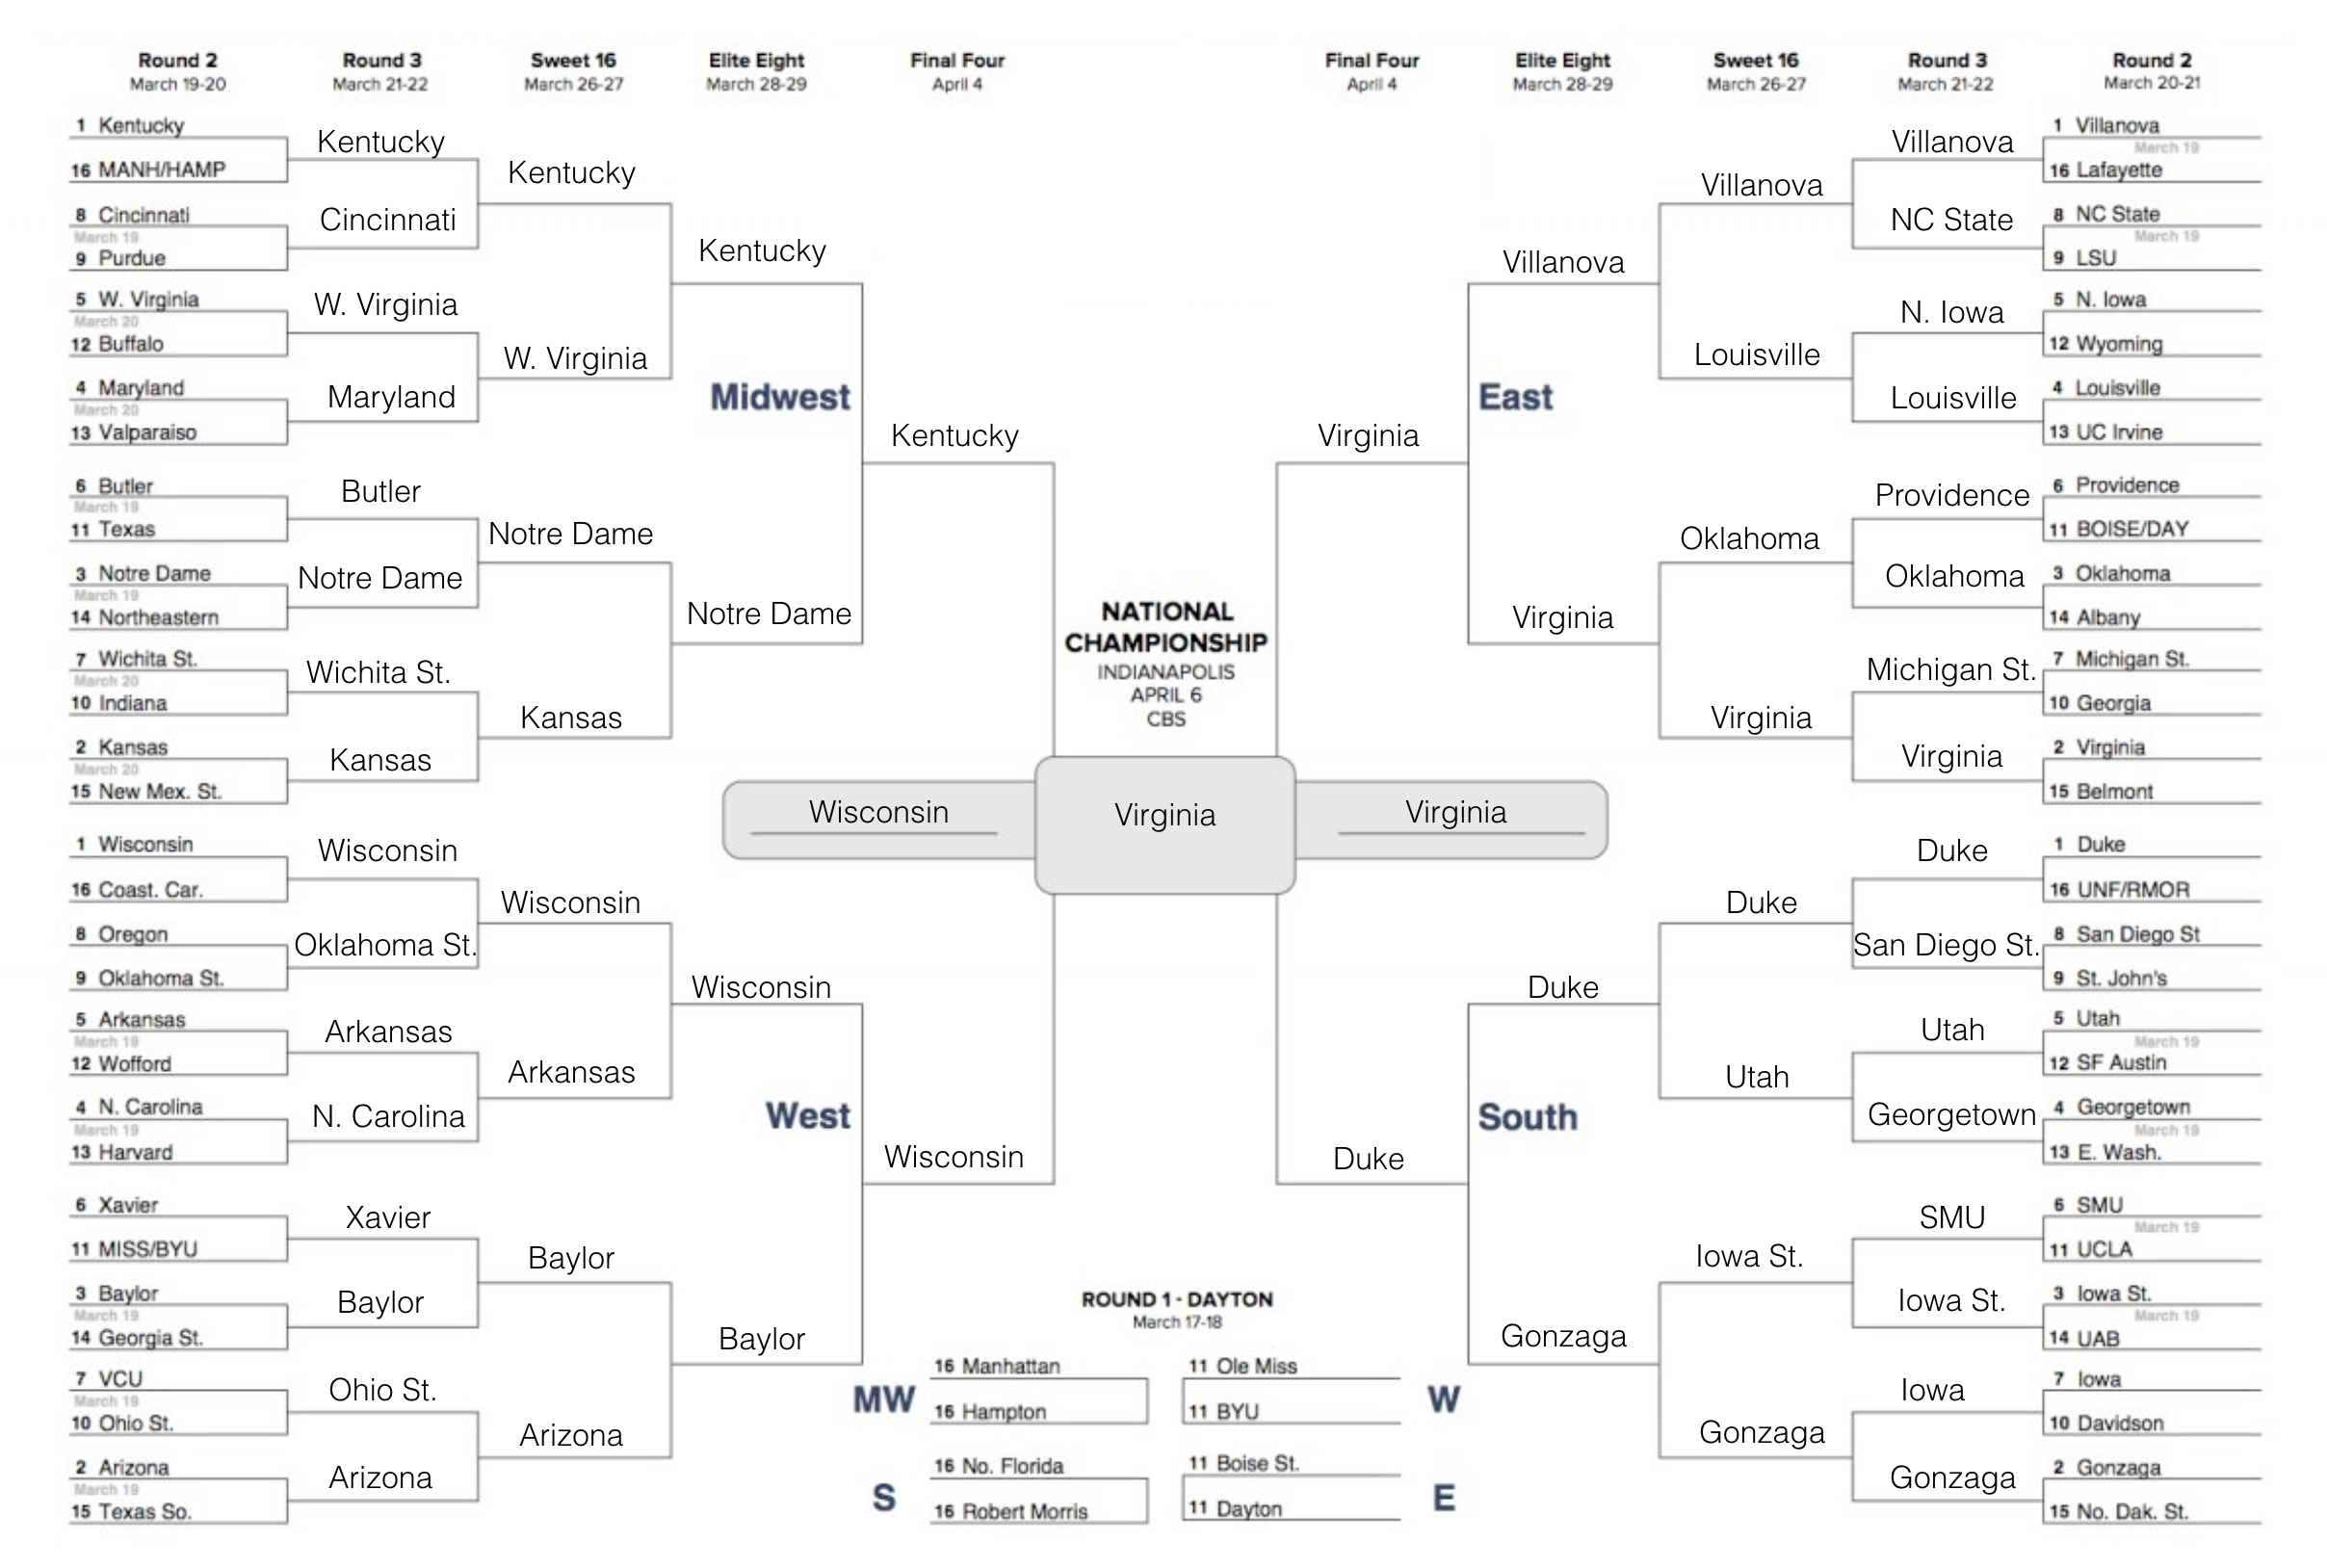

Total Score: **1070 / 1920**
<li> Round of 64: **270 / 320**</li>
<li> Round of 32: **200 / 320**</li>
<li> Sweet Sixteen: **200 / 320**</li>
<li> Elite Eight: **240 / 320**</li>
<li> Final Four: **160 / 320**</li>
<li> Championship: **0 / 320**</li>

For a 2015 bracket, a score of 1070 is a top 85.6 percentile bracket on ESPN.  Predicting by using our baseline model (only predicting based off of seed) gives a bracket score of 910.

What is especially interesting about our bracket is how it predicted that Wisonsin would beat Kentucky in the Final Four.  In 2015, most brackets predicted that Kentucky would win it all, however our bracket was correct in predicting this upset.

# Analysis
[Introduction](#Introduction) <br>
[Data Cleaning](#Data-Cleaning) <br>
[Data Exploration](#Data-Exploration) <br>
[Modeling](#Modeling) <br>
[Conclusion](#Conclusion) <br>

Since we are using logistic regression we could see which predictors are most useful.  Here is what our model tells us about each predictor.

In [42]:
logreg = LogReg(C=0.01)
logreg.fit(xtrain_window, ytrain_window)
coeffs = logreg.coef_[0]

for i in range(len(coeffs)):
    
    print col_vals[i+2], "coefficient =" ,round(coeffs[i],4)

Seed coefficient = 0.158
RegWin% coefficient = -0.0433
PointsWon% coefficient = -0.1365
AvgMargin coefficient = -0.1364
AvgFg% coefficient = -0.0815
AvgFg3% coefficient = -0.0234
AvgFt% coefficient = -0.0079
AvgOr coefficient = -0.016
AvgDr coefficient = -0.0031
AvgAst coefficient = -0.0708
AvgBlk coefficient = -0.0392
AvgStl coefficient = -0.0383
AvgPf coefficient = 0.0351
Momentum coefficient = -0.0288
WeightedWins coefficient = -0.106
RPI coefficient = -0.1076
SOS coefficient = -0.1203


Our model predicts 0 if Team A wins and 1 if Team B wins, so a negative coefficient actually means that it is important to have a higher number in this statistic. Seed is the most important variable that we look at. The lower the seed, the better chance a team has of winning. RPI, SOS, and "Weighted Wins" are also important, with teams with better RPI, SOS, and Weighted Wins performing better in the tournament, holding all else equal. In terms of in-game stats, teams that had a good field goal percentage and average assists during the regular season tend to do better, holding all else equal. This may point to the importance of shooting and ball movement in tournament games.

## Predicting Upsets

The hardest part with predicting March Madness is that in order to beat the baseline model is that you have to predict upsets.  One way we can build a model in order to predict upsets is by doing a balanced logistic regression on our training data.  Since our training data already labels upsets with a 1 and non-upsets with a 0, if we fit a model that predicts each response equally, then we'll have higher upset prediction accuracy.  Obviously this is problematic because it will lower our overall accuracy.

Here is our implementation of such a model.

Best C = 1
Max Accuracy = 0.671875


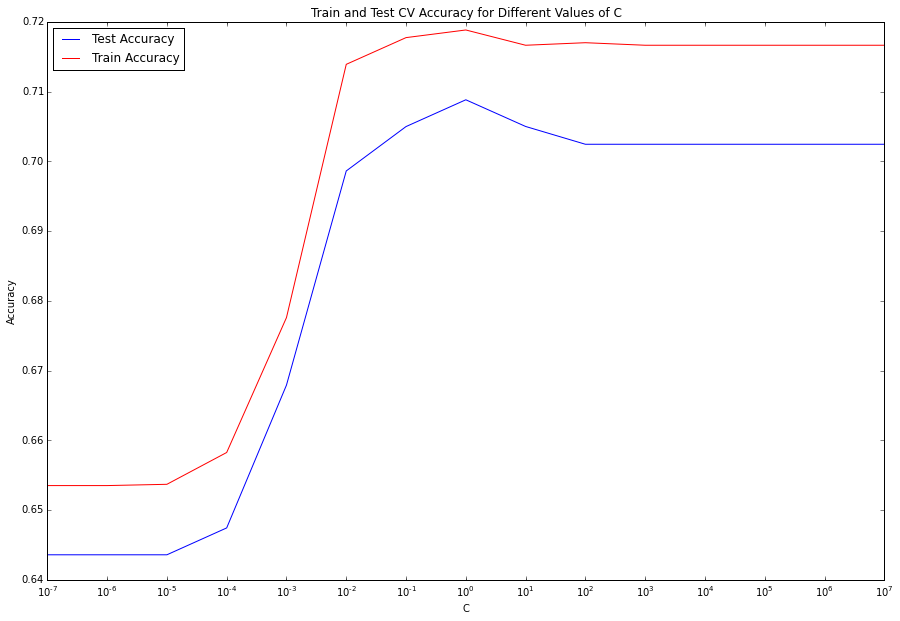

In [76]:
print getaccuracy('LogReg_Balance',xtrain_tuning,ytrain_tuning,xtrain_window,ytrain_window,xtest,ytest)

This balanced logistic regression performs significantly worse than the regular logistic regression.  This is expected.  Let's see how it does on the bracket.

In [68]:
# See how each model predicts rounds
modellist = ['LogReg_Balance']

year = 2015

# Create window, training data.
bracket_xtrain_window, bracket_ytrain_window = maketraindata(year, False)

# Create testing, bracket data.
bracket_xtest, bracket_ytest, bracketstartlist, initialsetup = maketestdata(year)

for item in modellist:
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R1')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R2')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R3')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds
    
    preds,amtcorrect = makebracket(item,bracket_xtrain_window,bracket_xtest,bracket_ytrain_window,bracket_ytest,year,'R4')
    print '**********************************'
    print '{}: {} correct'.format(item,amtcorrect)
    print preds

**********************************
LogReg_Balance: 21/32 correct
        Pred Team            Team
0         Arizona         Arizona
1        Arkansas        Arkansas
2           Texas          Butler
3      Cincinnati      Cincinnati
4      Georgetown      Georgetown
5          Baylor      Georgia St
6        Kentucky        Kentucky
7             LSU        NC State
8         Harvard  North Carolina
9      Notre Dame      Notre Dame
10        Ohio St         Ohio St
11            UAB             UAB
12           UCLA            UCLA
13           Utah            Utah
14      Villanova       Villanova
15    Mississippi          Xavier
16     Providence          Dayton
17           Duke            Duke
18    N Dakota St         Gonzaga
19           Iowa            Iowa
20  New Mexico St          Kansas
21     Louisville      Louisville
22     Valparaiso        Maryland
23        Georgia     Michigan St
24  Northern Iowa   Northern Iowa
25       Oklahoma        Oklahoma
26    Oklahoma St

This bracket clearly performs significantly worse than our previous overall.  The goal of this bracket is simply to try to predict upsets more accurately.  We can see that it does this with having Harvard make it all the way to the Sweet Sixteen, and San Diego State getting all the way to the Final Four. However, this is not the model that should be used to maximize points. The original model does much better with that. Instead, this bracket should do a better job at looking at high-variance picks, that may work out well. This model could be helpful for someone who is looking to maximize the chance they get first place in their group pool, rather than score the most possible points they can, which are not necessarily the same thing.

# Conclusion
[Introduction](#Introduction) <br>
[Data Cleaning](#Data-Cleaning) <br>
[Data Exploration](#Data-Exploration) <br>
[Modeling](#Modeling) <br>
[Analysis](#Analysis) <br>

At the beginning of the project, we set the following objectives:

1. Developing a model that will give us the bracket that we see as "most likely." This bracket would just pick every matchup with whichever team the model sees as having a better chance to win.

2. Using the same model to determine which bracket choices are most overrated. Is the general public overrating one team compared to our model? If so, it may be in your interest to pick more upsets in your bracket, to maximize your chance of winning your pool.

3. Determining which factors seem most important when predicting success in the tournament. This may provide greater insight to college basketball teams when determining any decision from who to recruit to developing a style of play.

We accomplished 1 with well over a thousand lines of code.  All of us agreed that our model is better than picking our own brackets by hand, so we'd definitely put our money on it if we weren't NCAA athletes.

We accomplished 2 but determined that a bracket that picks more upsets generally performs worse.

In looking at number 3 we were not really surprised by which predictors were useful and which were not. Seed is a pretty good predictor of who is going to win. The Selection Committee does a fairly good job at evaluating team strength, so any March Madness model should use this measure. We then saw the importance of RPI and SOS which are more analytical ways of evaluating team strength. Our most "useful" insight when looking at the predictors would be the importance of field goal percentage and assists. This would point to the importance of ball movement and shooting when predicting March Madness games.